In [5]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pickle
import functools
import operator 

def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    df["mode"] = df["catch_dropout"].fillna(1).map({0: 'REGRADS', 1: 'Vanilla Finetuning'})
    return df

# B_1 All runs combined

Relevant Run Generations:
Dataset Seed 1:
- 18_S0-3 (fertig)
- 16_S0-1
- 19_S0-1

Dataset Seed 2:
- 18_S4-5 (fertig)

In [6]:
df_64 = read_wandb_csv("data/B_0064_sweeps_400QNLI.csv")
df_256 = read_wandb_csv("data/B_0256_sweeps_100QNLI.csv")
df_1024 = read_wandb_csv("data/B_1024_sweeps_25QNLI.csv")

df_all = pd.concat([df_64,df_256,df_1024], axis=0, ignore_index=True)

# One Plot per Training Set Size

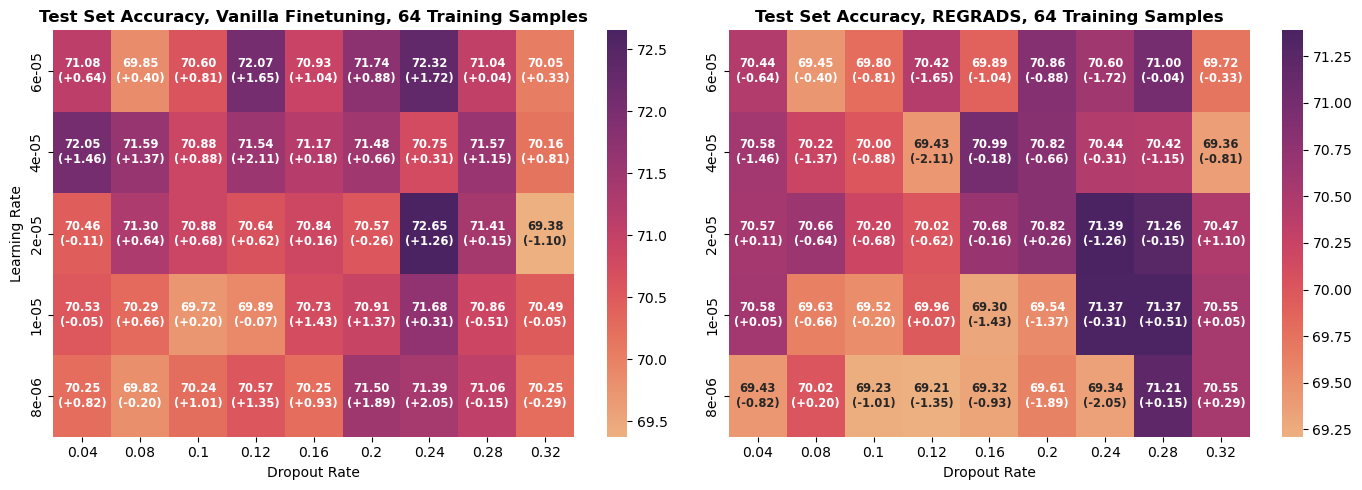

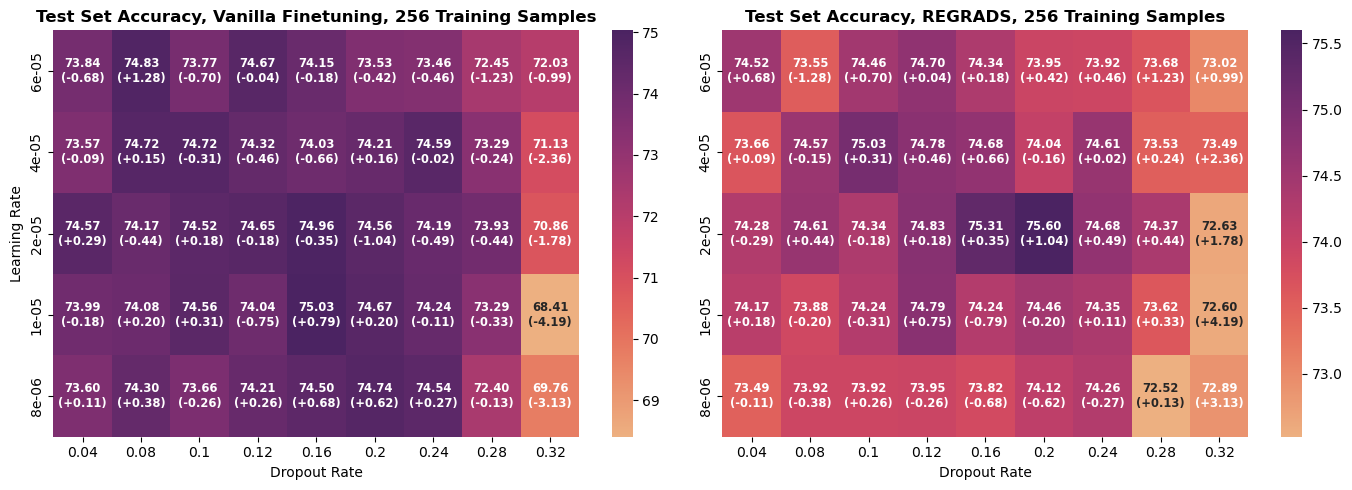

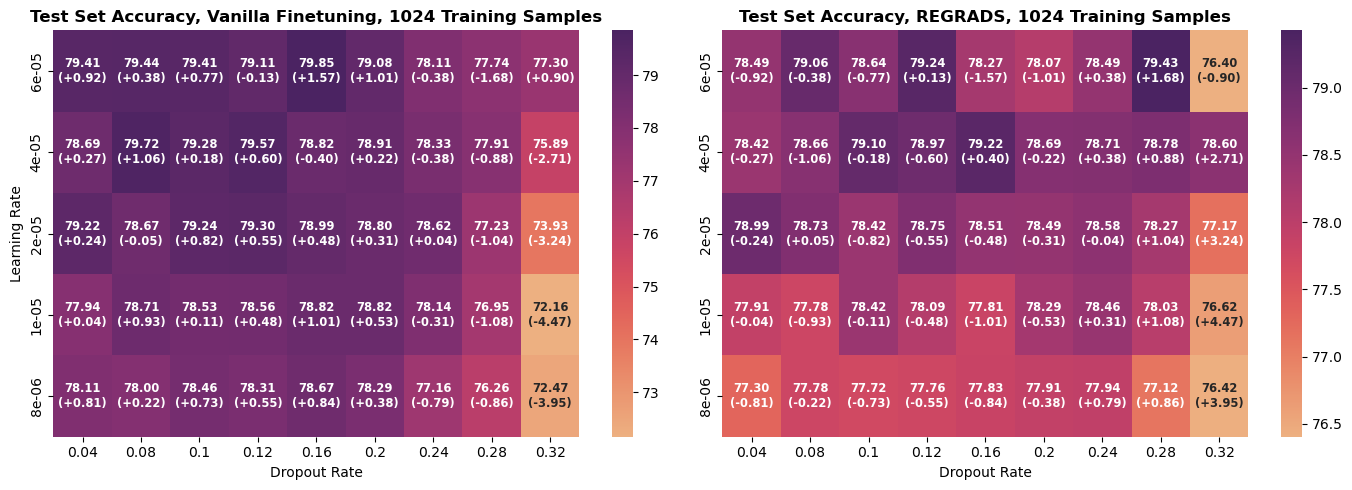

In [21]:
def generate_annotation(current_value, other_value, fmt):
    difference = current_value - other_value
    return f'{current_value:{fmt}}\n({difference:+.2f})'
vect_generate_annotation = np.vectorize(generate_annotation)


selected_rows = functools.reduce(
    operator.and_,
    [
        df_all["dataset_seed"] == 1
    ]  
    )
df = df_all.loc[selected_rows]

AGG_FUNCTION = 'median'

training_sizes = [64,256,1024]
subplot_columns = df["mode"].unique()[::-1] #["modded","vanilla"]

for idx, train_size in enumerate(training_sizes):
    train_size_filter = df["training_size"] == train_size
    pivots_dict = {}
    vmin = 100
    vmax = 0
    fig, axs = plt.subplots(
        1,
        len(subplot_columns),
        # sharey = True,
        figsize = (14,5),
        # figsize = (10,4),
        )
    for idy, col_key in enumerate(subplot_columns):
        mode_filter = df["mode"] == col_key
        filters = train_size_filter & mode_filter
        filtered_df = df.loc[filters]
        df_pivot = filtered_df.pivot_table(
            index=["learning_rate"],
            columns=["insert_dropout"],
            values=["best_accuracy"],
            aggfunc=AGG_FUNCTION
            )
        df_pivot = df_pivot.sort_index(ascending=False)
        df_pivot.columns = df_pivot.columns.droplevel(0)
        df_pivot = df_pivot * 100 # make values percentage
        # vmin = min(vmin,df_pivot.min().min())
        # vmax = max(vmax,df_pivot.max().max())
        vmin = min(vmin,df_pivot.melt().quantile(0.1).value)
        vmax = max(vmax,df_pivot.melt().quantile(0.9).value)
        pivots_dict[idy] = df_pivot
    
    for idy, df_pivot in pivots_dict.items():
        ax = axs[idy]
        other_df_pivot = pivots_dict[1-idy]  # assuming I have only two tags
        annot = vect_generate_annotation(df_pivot.values, other_df_pivot.values, '.2f')
        sns.heatmap(
            data=df_pivot,
            # annot=True,
            annot=annot,
            annot_kws={'weight':"bold", 'size': "small"},
            # fmt='.2f',
            fmt='',
            ax=ax,
            cmap='flare',  # Change the color palette to "crest"
            # vmin=vmin, 
            # vmax=vmax,
            cbar=True,
        )
        title = f'Test Set Accuracy, {subplot_columns[idy]}, {train_size} Training Samples'
        ax.set_title(title, weight='bold')
       
        ax.set_xlabel('Dropout Rate')
        if idy == 0:
            ax.set_ylabel('Learning Rate')
        if idy != 0:
            ax.set_ylabel('')


    fig.tight_layout()
    # fig.suptitle(f'Heatmap for Training Set Size: {train_size}',weight='bold')

    plt.savefig(f'img/B_heatmaps_lr_dropout_{train_size}.pdf', format='pdf')
        

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

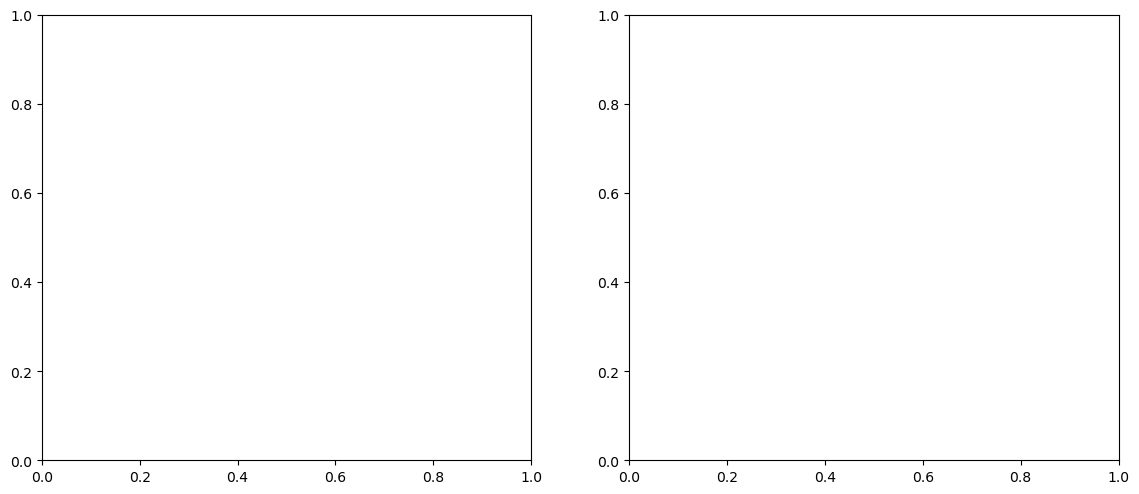

In [4]:

training_sizes = [64,256,1024]
tags = ["modded","vanilla"]
TEXTWIDTH = 5.78853
SCALER = 2
AGG_FUNCTION = 'median'
ratio = len(training_sizes) / len(tags) 


fig, axs = plt.subplots(
    len(training_sizes),
    len(tags),
    # sharex = True,
    # sharey = True,
    # figsize = (14,14)
    figsize = (1.2*SCALER*TEXTWIDTH,ratio*SCALER*TEXTWIDTH),
    # gridspec_kw={'width_ratios':[1]*len(tags) + [0.08]}
    )

def generate_annotation(current_value, other_value, fmt):
    difference = current_value - other_value
    return f'{current_value:{fmt}}\n({difference:+.2f})'
vect_generate_annotation = np.vectorize(generate_annotation)

external_filter = df_all["dataset_seed"] == 1
for idx, train_size in enumerate(training_sizes):
    train_size_filter = df_all["training_size"] == train_size
    pivots_dict = {}
    vmin = 100
    vmax = 0

    for idy, tag in enumerate(tags):
        mode_filter = df_all["Tags"].str.contains(tag)
        filters = external_filter & train_size_filter & mode_filter
        filtered_df = df_all.loc[filters]
        df_pivot = filtered_df.pivot_table(
            index=["learning_rate"],
            columns=["insert_dropout"],
            values=["best_accuracy"],
            aggfunc=AGG_FUNCTION
            )
        df_pivot = df_pivot.sort_index(ascending=False)
        df_pivot.columns = df_pivot.columns.droplevel(0)
        df_pivot = df_pivot * 100 # make values percentage
        # vmin = min(vmin,df_pivot.min().min())
        # vmax = max(vmax,df_pivot.max().max())
        vmin = min(vmin,df_pivot.melt().quantile(0.1).value)
        vmax = max(vmax,df_pivot.melt().quantile(0.9).value)
        pivots_dict[idy] = df_pivot

    # pivots_dict[len(tags)] = pivots_dict[0]-pivots_dict[1]

    
    for idy, df_pivot in pivots_dict.items():
        ax = axs[idx,idy]
        other_df_pivot = pivots_dict[1-idy]  # assuming you have only two tags
        annot = vect_generate_annotation(df_pivot.values, other_df_pivot.values, '.2f')
        sns.heatmap(
            data=df_pivot,
            # annot=True,
            annot=annot,
            annot_kws={'weight':"bold", 'size': "small"},
            # fmt='.2f',
            fmt='',
            ax=ax,
            cmap='flare',  # Change the color palette to "crest"
            # vmin=vmin, 
            # vmax=vmax,
            cbar=True,  # if idy != 0 else True,
            # cbar_ax=axs[idx, -1]
        )
        title = f'Training Size: {train_size}\nTag: {tags[idy]}'
        ax.set_title(title, weight='bold')
        if idy != 0:
            ax.set_ylabel('')
    
        if idx != len(training_sizes) - 1:
            ax.set_xlabel('')


fig.tight_layout()
plt.savefig('B_heatmaps_lr_dropout.pdf', format='pdf')
        